# Figure 1

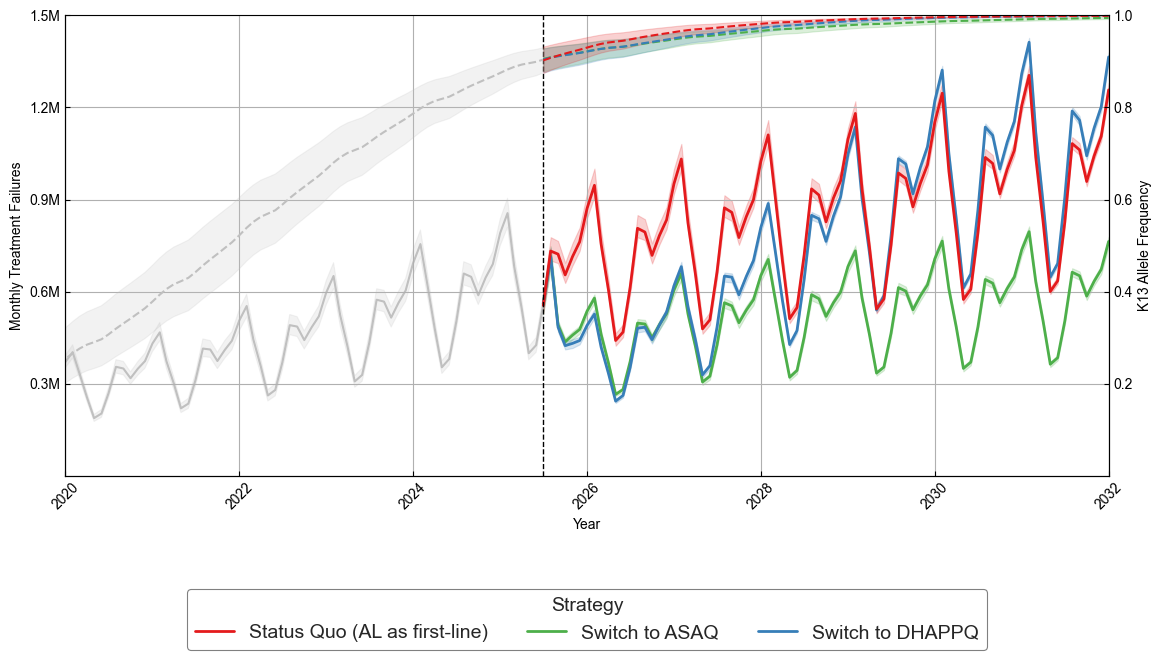

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import pandas as pd

# Adjust the y-axis to show values in millions
def millions_formatter(x, pos):
    return f'{x * 1e-6:.1f}M'  # Formats in millions with one decimal point

# --- Load and Prepare Data ---
csv_path = "./data/fig1_data.csv"  # Adjust path as needed
df = pd.read_csv(csv_path)
df['date'] = pd.to_datetime(df['date'])

# Filter scenarios
scenarios_to_plot = ["status_quo", "asaq", "dhappq"]
filtered_data = df[df['scenario'].isin(scenarios_to_plot)]
critical_point = pd.to_datetime("2025-07-01")

# --- Plot Configuration ---
# Update color scheme based on performance ranking
colors = {
    "asaq": "#4daf4a",       # Green: Best (ASAQ)
    "dhappq": "#377eb8",     # Purple: Intermediate (DHAPPQ)
    "status_quo": "#e41a1c", # Red: Worst (Status Quo)
}

pre_policy_color = "#c0c0c0"

# Determine tick positions
left_yticks = [0.3e6, 0.6e6, 0.9e6, 1.2e6, 1.5e6]
right_yticks = [tick / 1.5e6 for tick in left_yticks]  # normalize to [0, 1]

# Recreate the plot
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

sns.set_context("paper", font_scale=2)
sns.set_style("whitegrid")
pre = filtered_data[(filtered_data["date"] <= critical_point)]
sns.lineplot(data=pre, x='date', y='total_treatmentfailures', ax=ax1,
                 color=pre_policy_color, lw=1.5, alpha=1, zorder=1, errorbar=("pi", 90))
sns.lineplot(data=pre, x='date', y='k13_frequency', ax=ax2,
                 color=pre_policy_color, lw=1.5, alpha=1, zorder=1, linestyle='--',errorbar=("pi", 90))
# Plot lines
for scenario in colors:

    post = filtered_data[(filtered_data["scenario"] == scenario) & (filtered_data["date"] >= critical_point)]


    sns.lineplot(data=post, x='date', y='total_treatmentfailures', ax=ax1,
                 color=colors[scenario], lw=2, zorder=2,errorbar=("pi", 90))


    sns.lineplot(data=post, x='date', y='k13_frequency', ax=ax2,
                 color=colors[scenario], lw=1.5, zorder=2, linestyle='--',errorbar=("pi", 90))

# Background & vertical policy line
x_start = mdates.date2num(filtered_data['date'].min())
x_end = mdates.date2num(critical_point)
# ax1.add_patch(Rectangle((x_start, 0), x_end - x_start, 1.5e6, transform=ax1.transData,
                        # color=pre_policy_color, alpha=0.3, zorder=0))
ax1.axvline(critical_point, color='black', linestyle='--', lw=1, zorder=3)

# Axes setup
ax1.set_ylabel("Monthly Treatment Failures")
ax1.set_ylim([0, 1.5e6])
ax1.set_yticks(left_yticks)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))

ax2.set_ylabel("K13 Allele Frequency")
ax2.set_ylim([0, 1.0])
ax2.set_yticks(right_yticks)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:.1f}"))

# X-axis formatting
ax1.set_xlim([pd.to_datetime("2020-01-01"), pd.to_datetime("2032-01-01")])
ax1.set_xlabel("Year")
ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Grid & ticks
ax1.grid(True, axis='both')
ax2.grid(False)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', direction='in')
ax2.tick_params(axis='both', direction='in')

# Legend
legend_labels = {
    "status_quo": "Status Quo (AL as first-line)",
    "asaq": "Switch to ASAQ",
    "dhappq": "Switch to DHAPPQ"
}
custom_lines = [Line2D([0], [0], color=colors[key], lw=2) for key in legend_labels]
leg = ax1.legend(custom_lines, [legend_labels[k] for k in legend_labels],
           title="Strategy", frameon=True, fancybox=True, framealpha=1,
           facecolor='white', edgecolor='gray', fontsize=14, title_fontsize=14,
            loc='lower center', bbox_to_anchor=(0.5, -0.4),ncol=3
           )
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1)
frame.set_edgecolor('gray')

sns.despine(ax=ax1, right=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])
# plt.savefig("fig4_dual_axis.pdf", bbox_inches='tight')
plt.savefig("figure_1.png", dpi=300, bbox_inches='tight')
plt.show()


# Figure 2

max frequency in heatmap for run 30: 0.3093813246086006
max frequency in heatmap for run 0: 0.21587747048681416
max frequency in heatmap for run 10: 0.2717080599371128


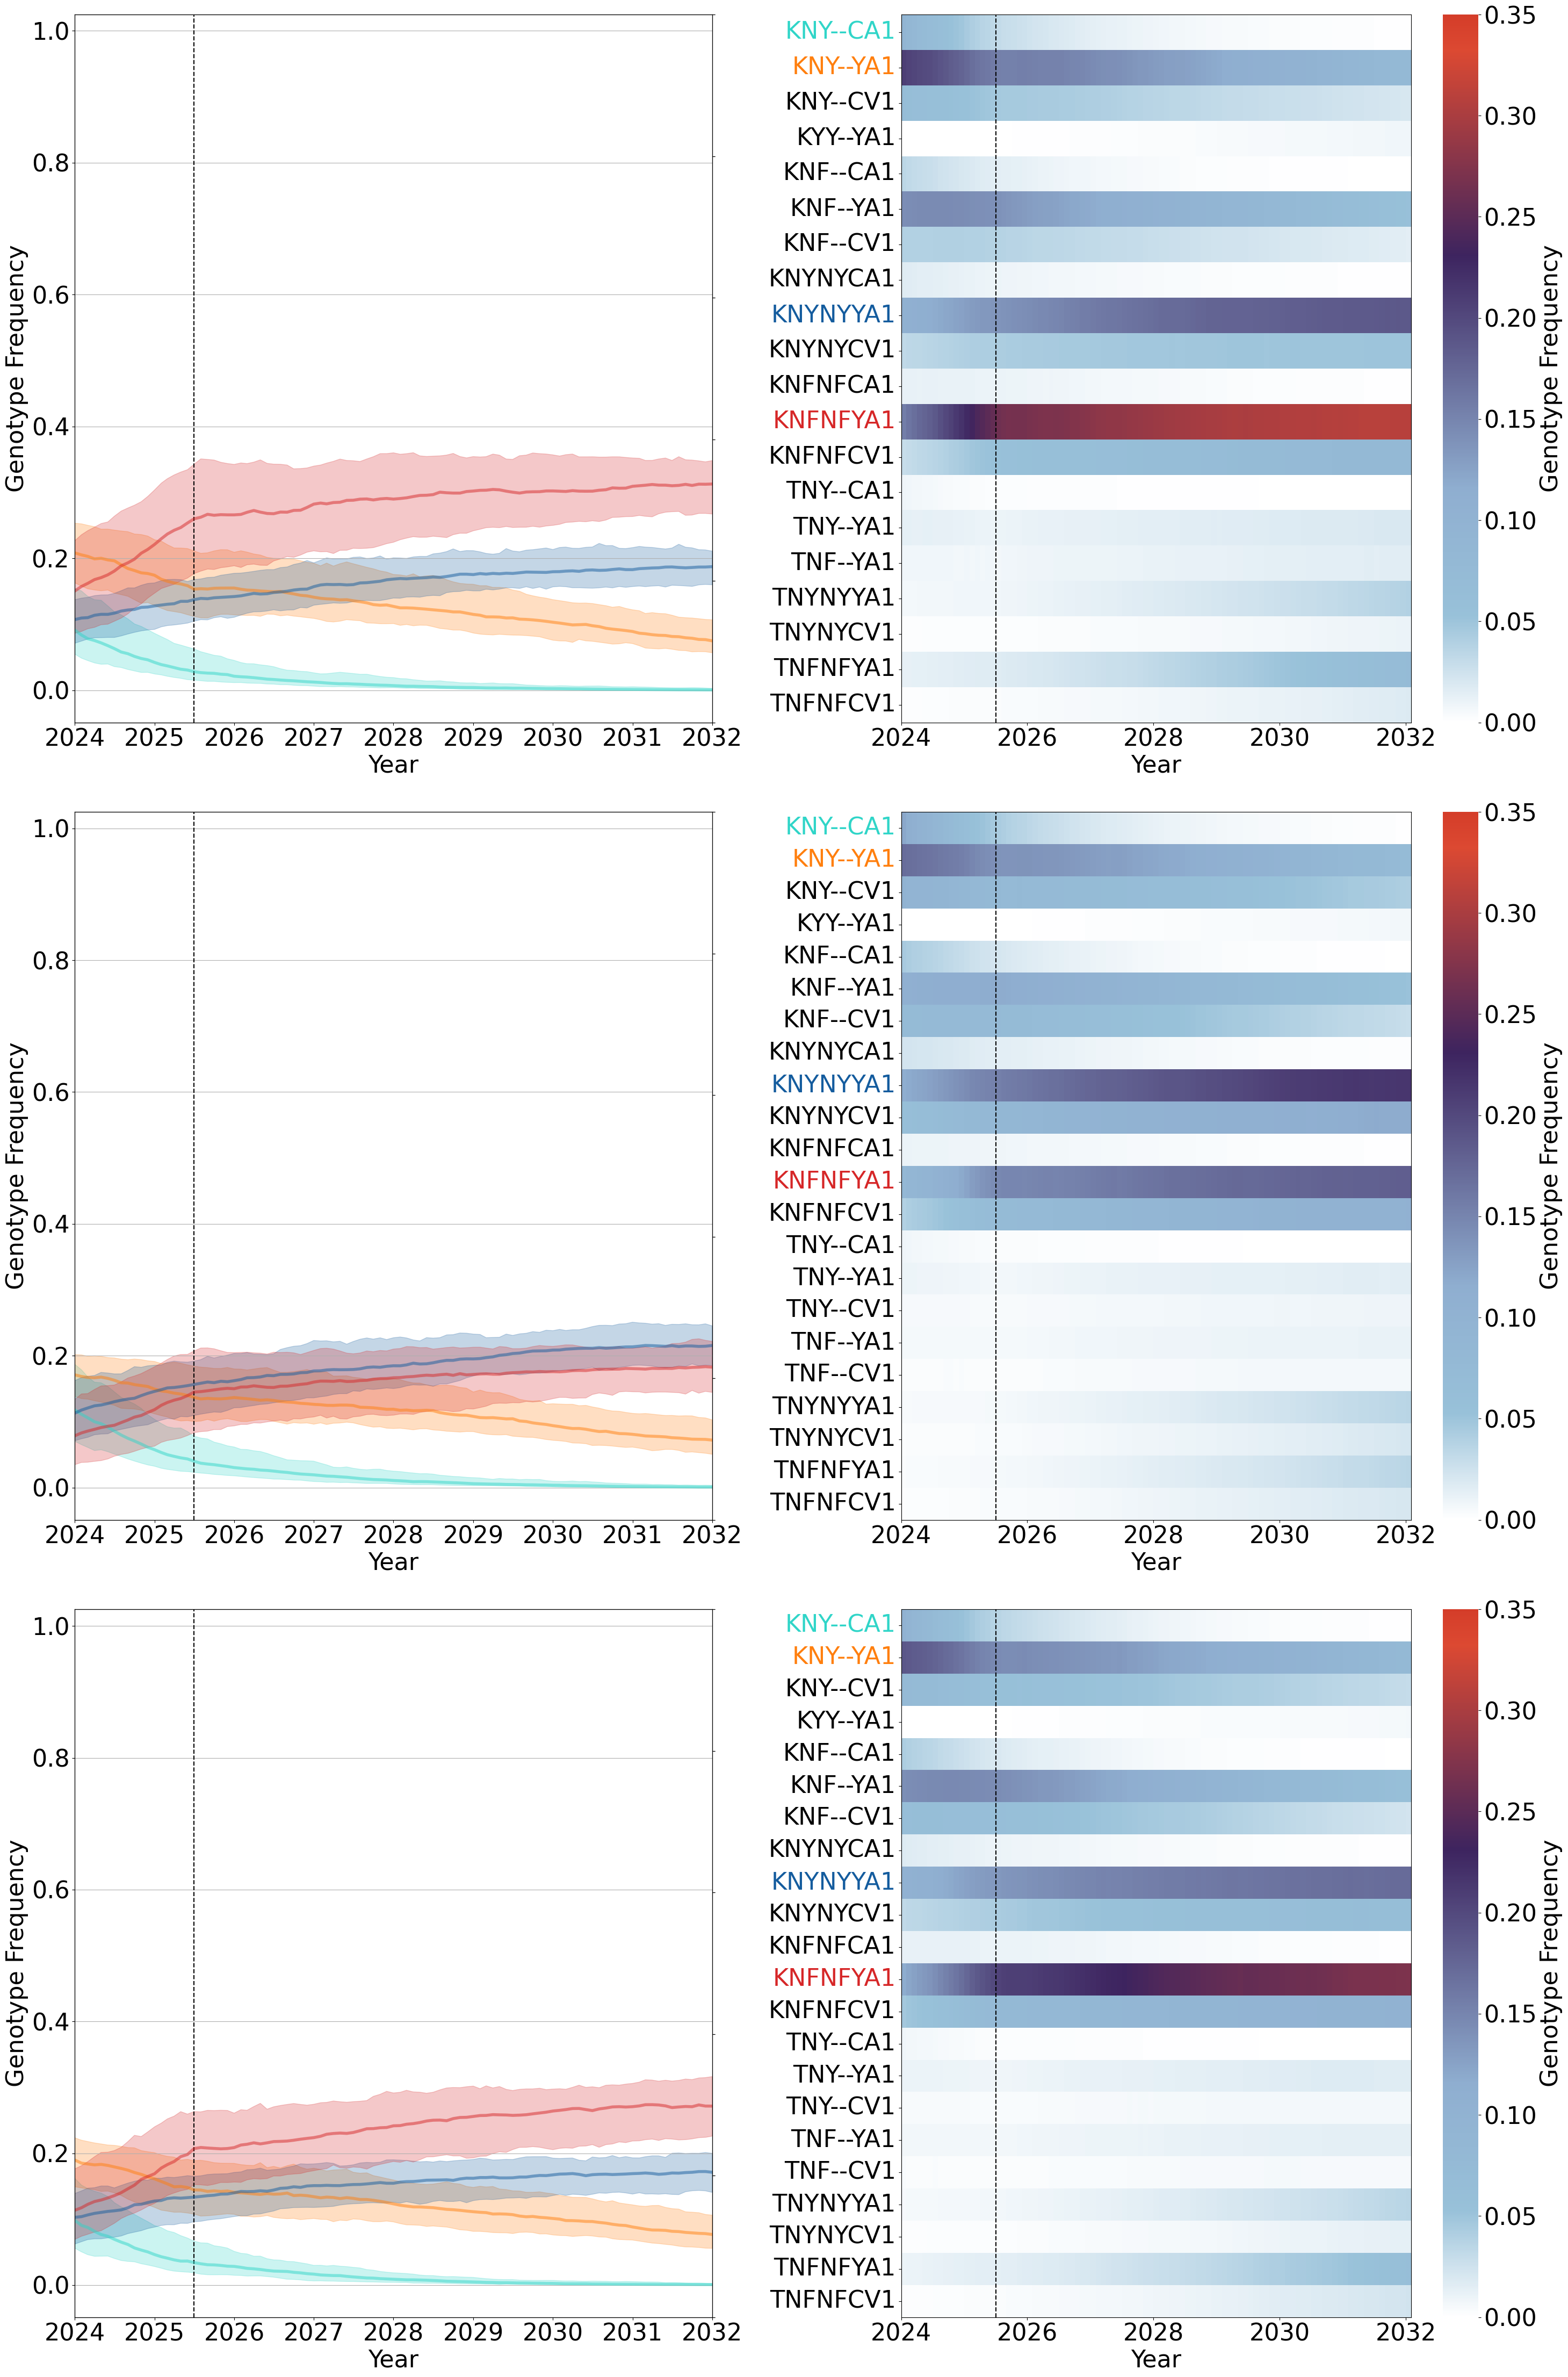

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sqlite3
from datetime import datetime
import numpy as np

def plot_freq_median_iqr(monthly_data, ax, frequency_limit, ylabel, xlimit=None, palette=None, lower_iqr=0.25, upper_iqr=0.75):
    """
    Plots the median and shades the IQR (25th to 75th percentile) for each genotype.

    Args:
    - monthly_data (DataFrame): The input dataframe containing genotype frequency data.
    - ax (matplotlib.axes._subplots.AxesSubplot): The axis on which to plot.
    - palette (str or list): A valid seaborn color palette name or list of colors.
    - frequency_limit (float): The frequency threshold to filter genotypes for plotting.
    """
    # Calculating median and IQR for each genotype
    median_df = monthly_data.groupby("date").median()
    iqr25_df = monthly_data.groupby("date").quantile(lower_iqr)
    iqr75_df = monthly_data.groupby("date").quantile(upper_iqr)

    # Dropping unnecessary columns
    median_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr25_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr75_df.drop(columns=["monthlydataid", "locationid"], inplace=True)

    # Keeping only columns that meet the threshold for median and IQR data
    median_df = median_df.loc[:, (median_df.max() > frequency_limit)]
    iqr25_df = iqr25_df.loc[:, (iqr25_df.max() > frequency_limit)]
    iqr75_df = iqr75_df.loc[:, (iqr75_df.max() > frequency_limit)]

    if palette is not None:
        sns.set_palette(palette)

    # Plotting the median lines for each genotype
    for column in median_df.columns:
        if median_df[column].max() > 0.15:
            plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color="k" if palette is None else None,alpha = 0.5)
        else:
            plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color="gray", alpha=0.0)
        # Shading between IQR 25 and 75 if median values are above the threshold        
        if column in iqr25_df.columns and column in iqr75_df.columns:
            if median_df[column].max() > 0.15:
                ax.fill_between(median_df.index, iqr25_df[column], iqr75_df[column], alpha=0.25)

    # Customize plot (optional, could be part of the function or done outside)
    ax.legend().remove()
    ax.set_ylabel(ylabel)
    if xlimit:
        ax.set_xlim(xlimit)
    else:
        ax.set_xlim(median_df.index.min(), median_df.index.max())
    ax.set_xlabel("Year")
    ax.grid(axis='y')
    
    return median_df,plot

def plot_freq_median_iqr_v2(monthly_data, ax, ylabel, selected_genotypes, xlimit=None, lower_iqr=0.25, upper_iqr=0.75):
    """
    Plots the median and shades the IQR (25th to 75th percentile) for each selected genotype.
    """
    # Calculating median and IQR for each genotype
    median_df = monthly_data.groupby("date").median()
    iqr25_df = monthly_data.groupby("date").quantile(lower_iqr)
    iqr75_df = monthly_data.groupby("date").quantile(upper_iqr)

    # Dropping unnecessary columns
    median_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr25_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr75_df.drop(columns=["monthlydataid", "locationid"], inplace=True)

    # filtering median_df, iqr25_df, iqr75_df to only include selected_genotypes
    median_df = median_df.loc[:, median_df.columns.isin(selected_genotypes.keys())]
    iqr25_df = iqr25_df.loc[:, iqr25_df.columns.isin(selected_genotypes.keys())]
    iqr75_df = iqr75_df.loc[:, iqr75_df.columns.isin(selected_genotypes.keys())]


    # Plotting the median lines for each genotype
    for column in median_df.columns:
        # print(f"Plotting genotype: {column}")
        # get color from selected_genotypes
        color = selected_genotypes.get(column, "gray")
        # plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color=color, alpha=0.0)
        ax.fill_between(median_df.index, iqr25_df[column], iqr75_df[column], alpha=0.25, color=color)
        plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color=color,alpha = 0.5, zorder=3)

    # Customize plot (optional, could be part of the function or done outside)
    ax.legend().remove()
    ax.set_ylabel(ylabel)
    if xlimit:
        ax.set_xlim(xlimit)
    else:
        ax.set_xlim(median_df.index.min(), median_df.index.max())
    ax.set_xlabel("Year")
    ax.grid(axis='y')
    
    return median_df,plot

frequency_limit = 0.005
runs = [30, 0, 10]
sns.reset_defaults()
rc = {
    # "font.family" : "Consolas", 
      "font.style" : "normal",
      "font.size" : 32,
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)

fig,axes = plt.subplots( len(runs),2,figsize=(30,15* len(runs)),sharex=False)
for i, run in enumerate(runs):
    ax0 = axes[i,0]
    ax1 = axes[i,1]
    
    monthly_gen_frequency = pd.read_csv(f"./data/fig2_data_{run}.csv")
    monthly_gen_frequency['date'] = pd.to_datetime(monthly_gen_frequency['date'])
    plot_df = monthly_gen_frequency.groupby("date").mean().drop(columns=["monthlydataid", "locationid"])

    plot_df = plot_df.T

    colors = [
        (0.0, 'white'),      # 0.0 is white
        (0.15, '#98c1d9'),    # light blue
        (0.33, '#8faed0'),    # more visible blue
        # (0.40, '#6f4b9b'),    # stronger dark violet-blue
        # (0.46, '#4e3378'),    # darker violet
        (0.66, '#3d245f'),    # deep violet
        # (0.75, '#ee6c4d'),    # light orange
        # (0.85, '#e86044'),
        # (0.9, '#e2553b'),
        (0.95, '#dc4932'),
        (1.0, '#d43d29')     # deeper orange
    ]

    cmap= LinearSegmentedColormap.from_list("custom_cmap", colors, N=512)

    date_to_plot = (datetime(2024,1,1), datetime(2032,1,1))

    selected_genotypes = {
        'KNY--CA1': '#30d5c8',
        'KNY--YA1': '#ff7f0e',
        'KNYNYYA1': '#145c9e',
        'KNFNFYA1': '#d62728',
    }

    freq_median_df,freq_median_plot = plot_freq_median_iqr_v2(monthly_gen_frequency, ax0, 
                                                         "Genotype Frequency", 
                                                        selected_genotypes, xlimit=date_to_plot,
                                                        lower_iqr=0.05, upper_iqr=0.95)

    #set plot_df column in date_to_plot
    plot_df = plot_df.loc[:,date_to_plot[0]:date_to_plot[1]]

 # Determine which rows have all values <= 0.01
    mask = plot_df.max(axis=1) > frequency_limit  # Change 'max' to another function if a different logic is needed
    plot_df = plot_df[mask]

    plot = sns.heatmap(plot_df, yticklabels=True,xticklabels=True,
                        cmap=cmap, vmin=0, vmax=0.35, 
                        cbar_kws={'label': 'Genotype Frequency'},
                        ax=ax1)
    print(f"max frequency in heatmap for run {run}: {plot_df.values.max()}")

    # plot.collections[0].colorbar.ax.set_ylim(0, 0.5)
    #display border for heatmap
    plot.spines['top'].set_visible(True)
    plot.spines['bottom'].set_visible(True)
    plot.spines['left'].set_visible(True)
    plot.spines['right'].set_visible(True)
    plot_df_columns = [date.strftime('%Y') for date in plot_df.columns]

    #set the color of yticklabels using the same color as the lineplot in axes[0]
    #check if the label name matched label in lineplot
    for label in plot.get_yticklabels():
        if label.get_text() in freq_median_df.columns:
            label.set_color(freq_median_plot.get_lines()[list(freq_median_df.columns).index(label.get_text())].get_color())
        else:
            label.set_color("black")

    xticklabels = [date.strftime('%Y') if (date.month == 1) & (date.year % 2 ==0) else '' for date in plot_df.columns]
    ticks = [i for i, label in enumerate(xticklabels) if label] 
    ax1.set_xticks(ticks=ticks, labels=[xticklabels[i] for i in ticks], rotation=0)  # Adjust rotation if needed
    ax1.set_xlabel('Year')
    pos = np.where(plot_df.columns == datetime(2025, 7, 1))[0][0]
    ax0.axvline(x=datetime(2025,7,1), color='k', linestyle='--')
    ax1.axvline(x=pos, color='k', linestyle='--')

    axes_pfpr = ax0.twinx()
    axes_tf = ax0.twinx()

    axes_pfpr.set_yticklabels([])
    axes_tf.set_yticklabels([])
    axes_pfpr.set_ylabel("")
    axes_tf.set_ylabel("")

plt.tight_layout()
plt.show()
fig.savefig(f"figure_2.png", dpi=300)

# Figure 3

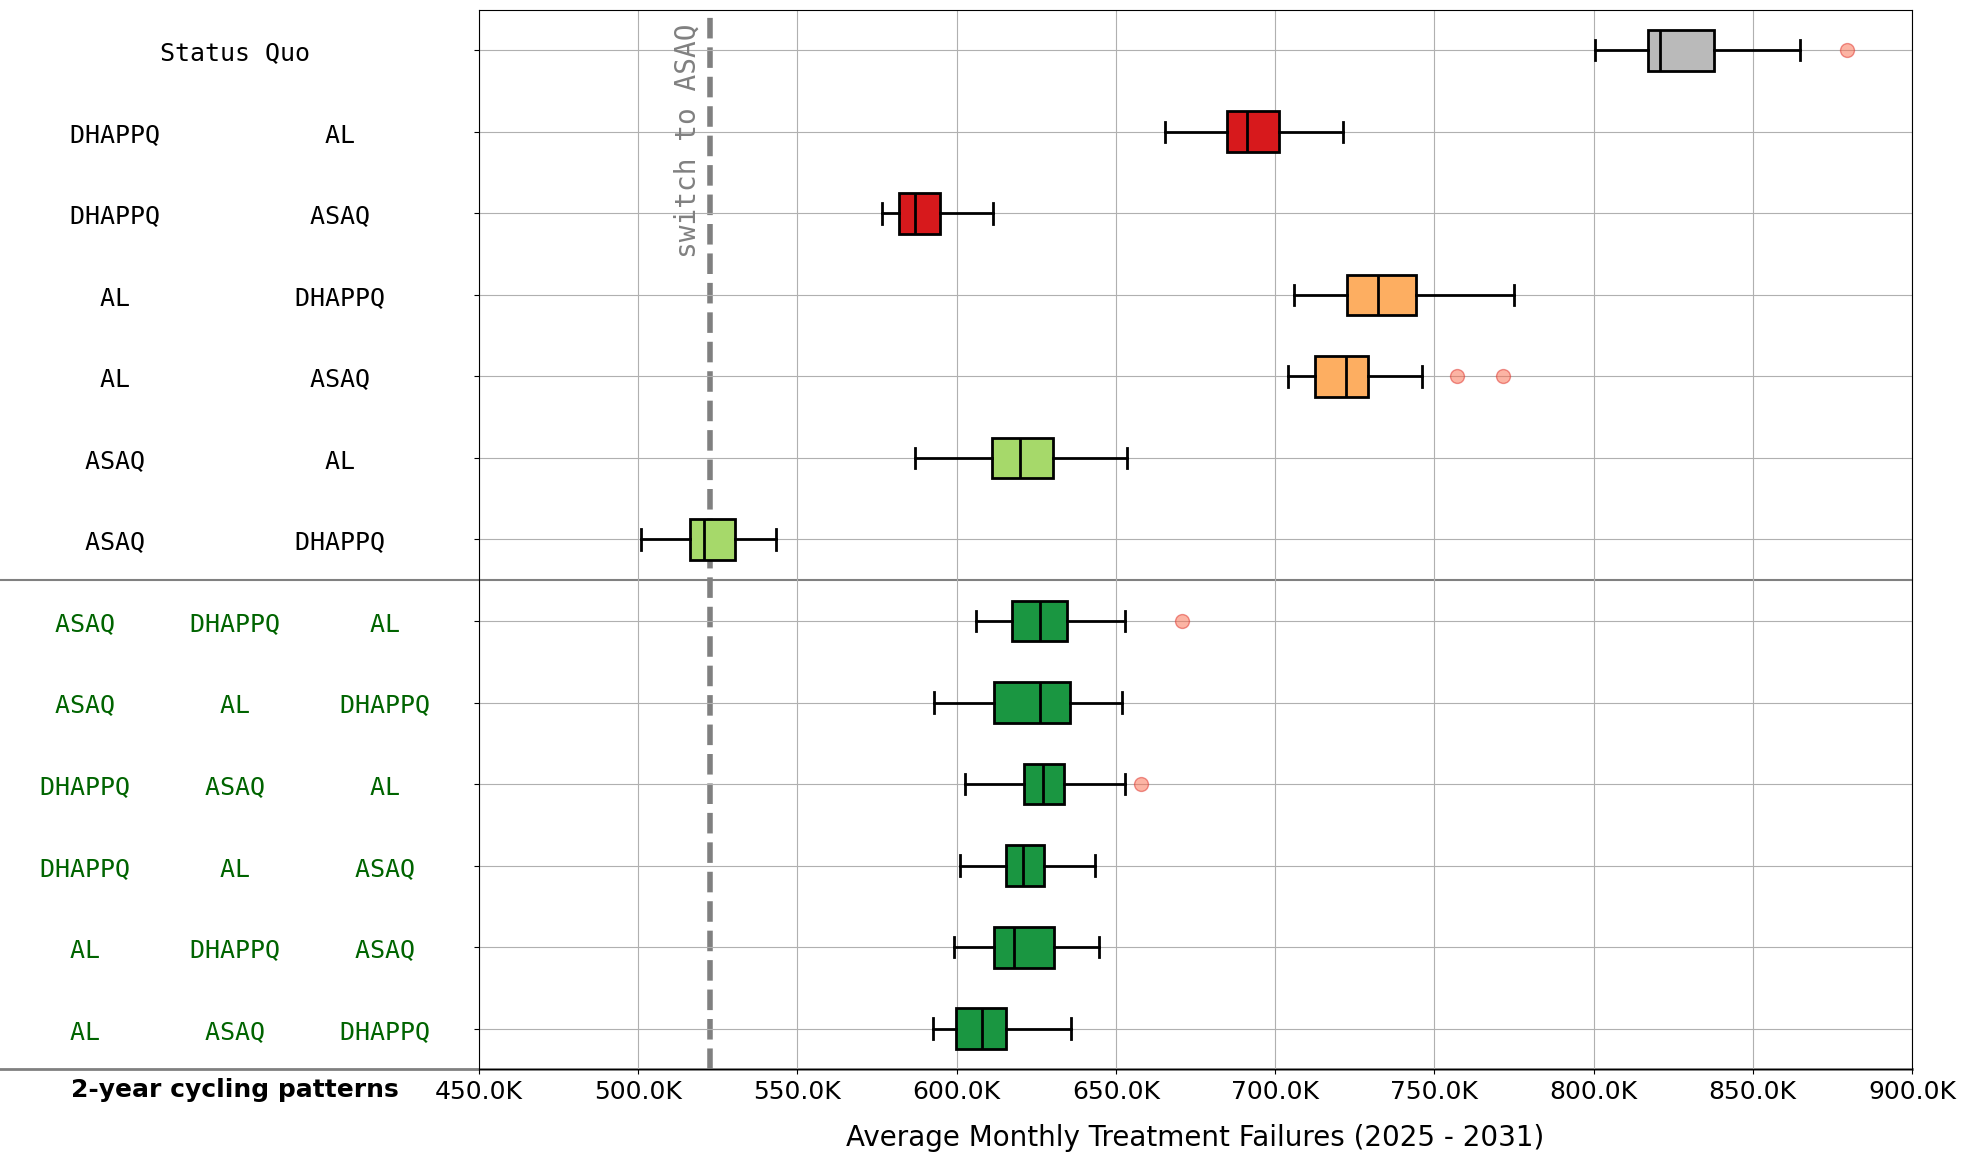

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Custom formatter function for x-axis
def thousands_formatter(x, pos):
    return f'{int(x) / 1e3}K'

cycling_stategies = {
    "cycling_dhappq_al_2y": {"label": "DHAPPQ-AL", "color": "#d7191c", "position": 0},
    "cycling_dhappq_asaq_2y": {"label": "DHAPPQ-ASAQ", "color": "#d7191c", "position": 0},
    "cycling_al_dhappq_2y": {"label": "AL-DHAPPQ", "color": "#fdae61", "position": 0},
    "cycling_al_asaq_2y": {"label": "AL-ASAQ", "color": "#fdae61", "position": 0},
    "cycling_asaq_al_2y": {"label": "ASAQ-AL", "color": "#a6d96a", "position": 0},
    "cycling_asaq_dhappq_2y": {"label": "ASAQ-DHAPPQ", "color": "#a6d96a", "position": 0},
    "cycling_asaq_dhappq_al_2y": {"label": "ASAQ-DHAPPQ-AL", "color": "#1a9641", "position": 0},
    "cycling_asaq_al_dhappq_2y": {"label": "ASAQ-AL-DHAPPQ", "color": "#1a9641", "position": 0},
    "cycling_dhappq_asaq_al_2y": {"label": "DHAPPQ-ASAQ-AL", "color": "#1a9641", "position": 0},
    "cycling_dhappq_al_asaq_2y": {"label": "DHAPPQ-AL-ASAQ", "color": "#1a9641", "position": 0},
    "cycling_al_dhappq_asaq_2y": {"label": "AL-DHAPPQ-ASAQ", "color": "#1a9641", "position": 0},
    "cycling_al_asaq_dhappq_2y": {"label": "AL-ASAQ-DHAPPQ", "color": "#1a9641", "position": 0},
}

# Setting
corrected_scenario_mapping_dict = {"status_quo": {"label": "Status Quo", "color": "#bababa"}}
corrected_scenario_mapping_dict.update(cycling_stategies)

for i, key in enumerate(corrected_scenario_mapping_dict):
    corrected_scenario_mapping_dict[key]['position'] = -i

group_endings = ["cycling_asaq_dhappq_2y", "cycling_al_asaq_dhappq_2y"]

# Define total width (divisible by 6 for flexibility)
total_width = 30
col_width_3 = total_width // 3  # Width for each column in 3-column rows
col_width_2 = total_width // 2  # Width for each column in 3-column rows

# Extract labels from the dictionary, split by "-" and format them
y_ticks_dynamic = []
for key in corrected_scenario_mapping_dict:
    labels = corrected_scenario_mapping_dict[key]['label'].split('-')
    if len(labels) == 1:  # 1 column
        labels = [labels[0]]
        formatted_label = ''.join([f"{label:^{total_width}}" for label in labels])
    elif len(labels) == 2:  # 2 columns
        # labels.append(labels[0])  # Repeat the first label
        formatted_label = ''.join([f"{label:^{col_width_2}}" for label in labels])
    else:  # 3 columns
        formatted_label = ''.join([f"{label:^{col_width_3}}" for label in labels])
    y_ticks_dynamic.append(formatted_label)

# print(y_ticks_dynamic)
# for label in y_ticks_dynamic:
#     print(f"'{label}' length: {len(label)}")

# Load the dataset
data_path = './data/ntfs_6y.csv'
data_labeled = pd.read_csv(data_path)
data_labeled = data_labeled[(data_labeled["scenario"].isin(corrected_scenario_mapping_dict.keys())) & (data_labeled["year"] == 2031)]
data_labeled["total_treatmentfailures"] = data_labeled["total_treatmentfailures"] / (6 * 12)

data_labeled['position'] = data_labeled['scenario'].apply(lambda x: corrected_scenario_mapping_dict[x]['position'])

# Introduce variables for box width and spacing
box_width = 0.2  # Can be adjusted for narrower or wider boxes
spacing_multiplier = 0.4  # Adjust this to make boxplots closer or further apart
dynamic_positions = {scenario: details["position"] * spacing_multiplier for scenario, details in corrected_scenario_mapping_dict.items()}

# Calculate dynamic positions for dashed lines
adjusted_group_separators = [dynamic_positions[scenario] - 0.5 * spacing_multiplier for scenario in group_endings[:-1]]  # Adjust, exclude last

plt.rcdefaults()
plt.rcParams['font.size'] = 18
lw = 2
outlier_size = 10

# Create the plots with corrected positions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12), sharey=False, sharex=False)

for scenario, details in corrected_scenario_mapping_dict.items():
    scenario_data = data_labeled[(data_labeled['scenario'] == scenario) & (data_labeled['year'] == 2031)]['total_treatmentfailures']
    if not scenario_data.empty:
        ax.boxplot(scenario_data, positions=[dynamic_positions[scenario]], 
                   widths=box_width, vert=False, patch_artist=True,
                   boxprops=dict(facecolor=details['color'], color='black', linewidth=lw),
                   whiskerprops=dict(color='black', linewidth=lw),
                   capprops=dict(color='black', linewidth=lw),
                   medianprops=dict(color='black', linewidth=lw),
                   flierprops=dict(marker='o', markerfacecolor='#fb6a4a', markeredgecolor='#de2d26', alpha=0.5, markersize=outlier_size)
                   )
for separator in adjusted_group_separators:
    ax.axhline(y=separator, xmin=-1.2,
                   color='grey', linestyle='-',
                  zorder=0,
                     clip_on=False)
                   


# Set tick positions and custom labels
ax.set_yticks(list(dynamic_positions.values()))
ax.set_yticklabels(y_ticks_dynamic, fontname='monospace') 

# Adjust tick parameters for better padding
ax.tick_params(axis='y', pad=10)

# Change the color of 3-column labels to dark green
for i, tick in enumerate(ax.get_yticklabels()):
    if i > 6:  # First 3 rows are 3-column labels
        tick.set_color("darkgreen")

ax.set_xlim(450000, 900000)
min_y = min(dynamic_positions.values()) - 0.5 * spacing_multiplier
max_y = max(dynamic_positions.values()) + 0.5 * spacing_multiplier
ax.set_ylim(min_y, max_y)

ax.axhline(
    y=min_y,  # Line position
    xmin=-1.2,  # Extend into tick label region
    xmax=1,  # Span across the plot
    c="grey",  # Line color
    linewidth=2,  # Line thickness
    zorder=0,  # Ensure it renders behind the bars
    clip_on=False,  # Allow line to extend beyond axes
)

ax.axvline(
    x=522456,  # Line position
    c="grey",  # Line color
    linewidth=4,  # Line thickness
    linestyle = '--',
    zorder=0,  # Ensure it renders behind the bars
    clip_on=True,  # Allow line to extend beyond axes
)

ax.text(
    520000,  # Position on the x-axis
    -0.44,  # Position on the y-axis
    "switch to ASAQ",
    fontweight="normal",
    fontname='monospace',
    fontsize = 20,
    color="grey",
    rotation=90,
    va="center",
    ha="right",
)
# Add a general label at -0.5
ax.text(
    425000,  # Position on the x-axis
    min_y - 0.25 * spacing_multiplier ,  # Position on the y-axis
    "2-year cycling patterns",
    fontweight="bold",
    color="black",
    va="center",
    ha="right",
)


ax.set_xlabel('Average Monthly Treatment Failures (2025 - 2031)', fontsize=20, labelpad=15)
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the custom formatter
ax.grid(axis='both')

plt.tight_layout()
plt.savefig("figure_3.png", format="png", dpi=300)
plt.show()

# Figure 4

max frequency in heatmap for run 1: 0.3114541535473489
max frequency in heatmap for run 10: 0.243361866498495
max frequency in heatmap for run 30: 0.20181034371365367


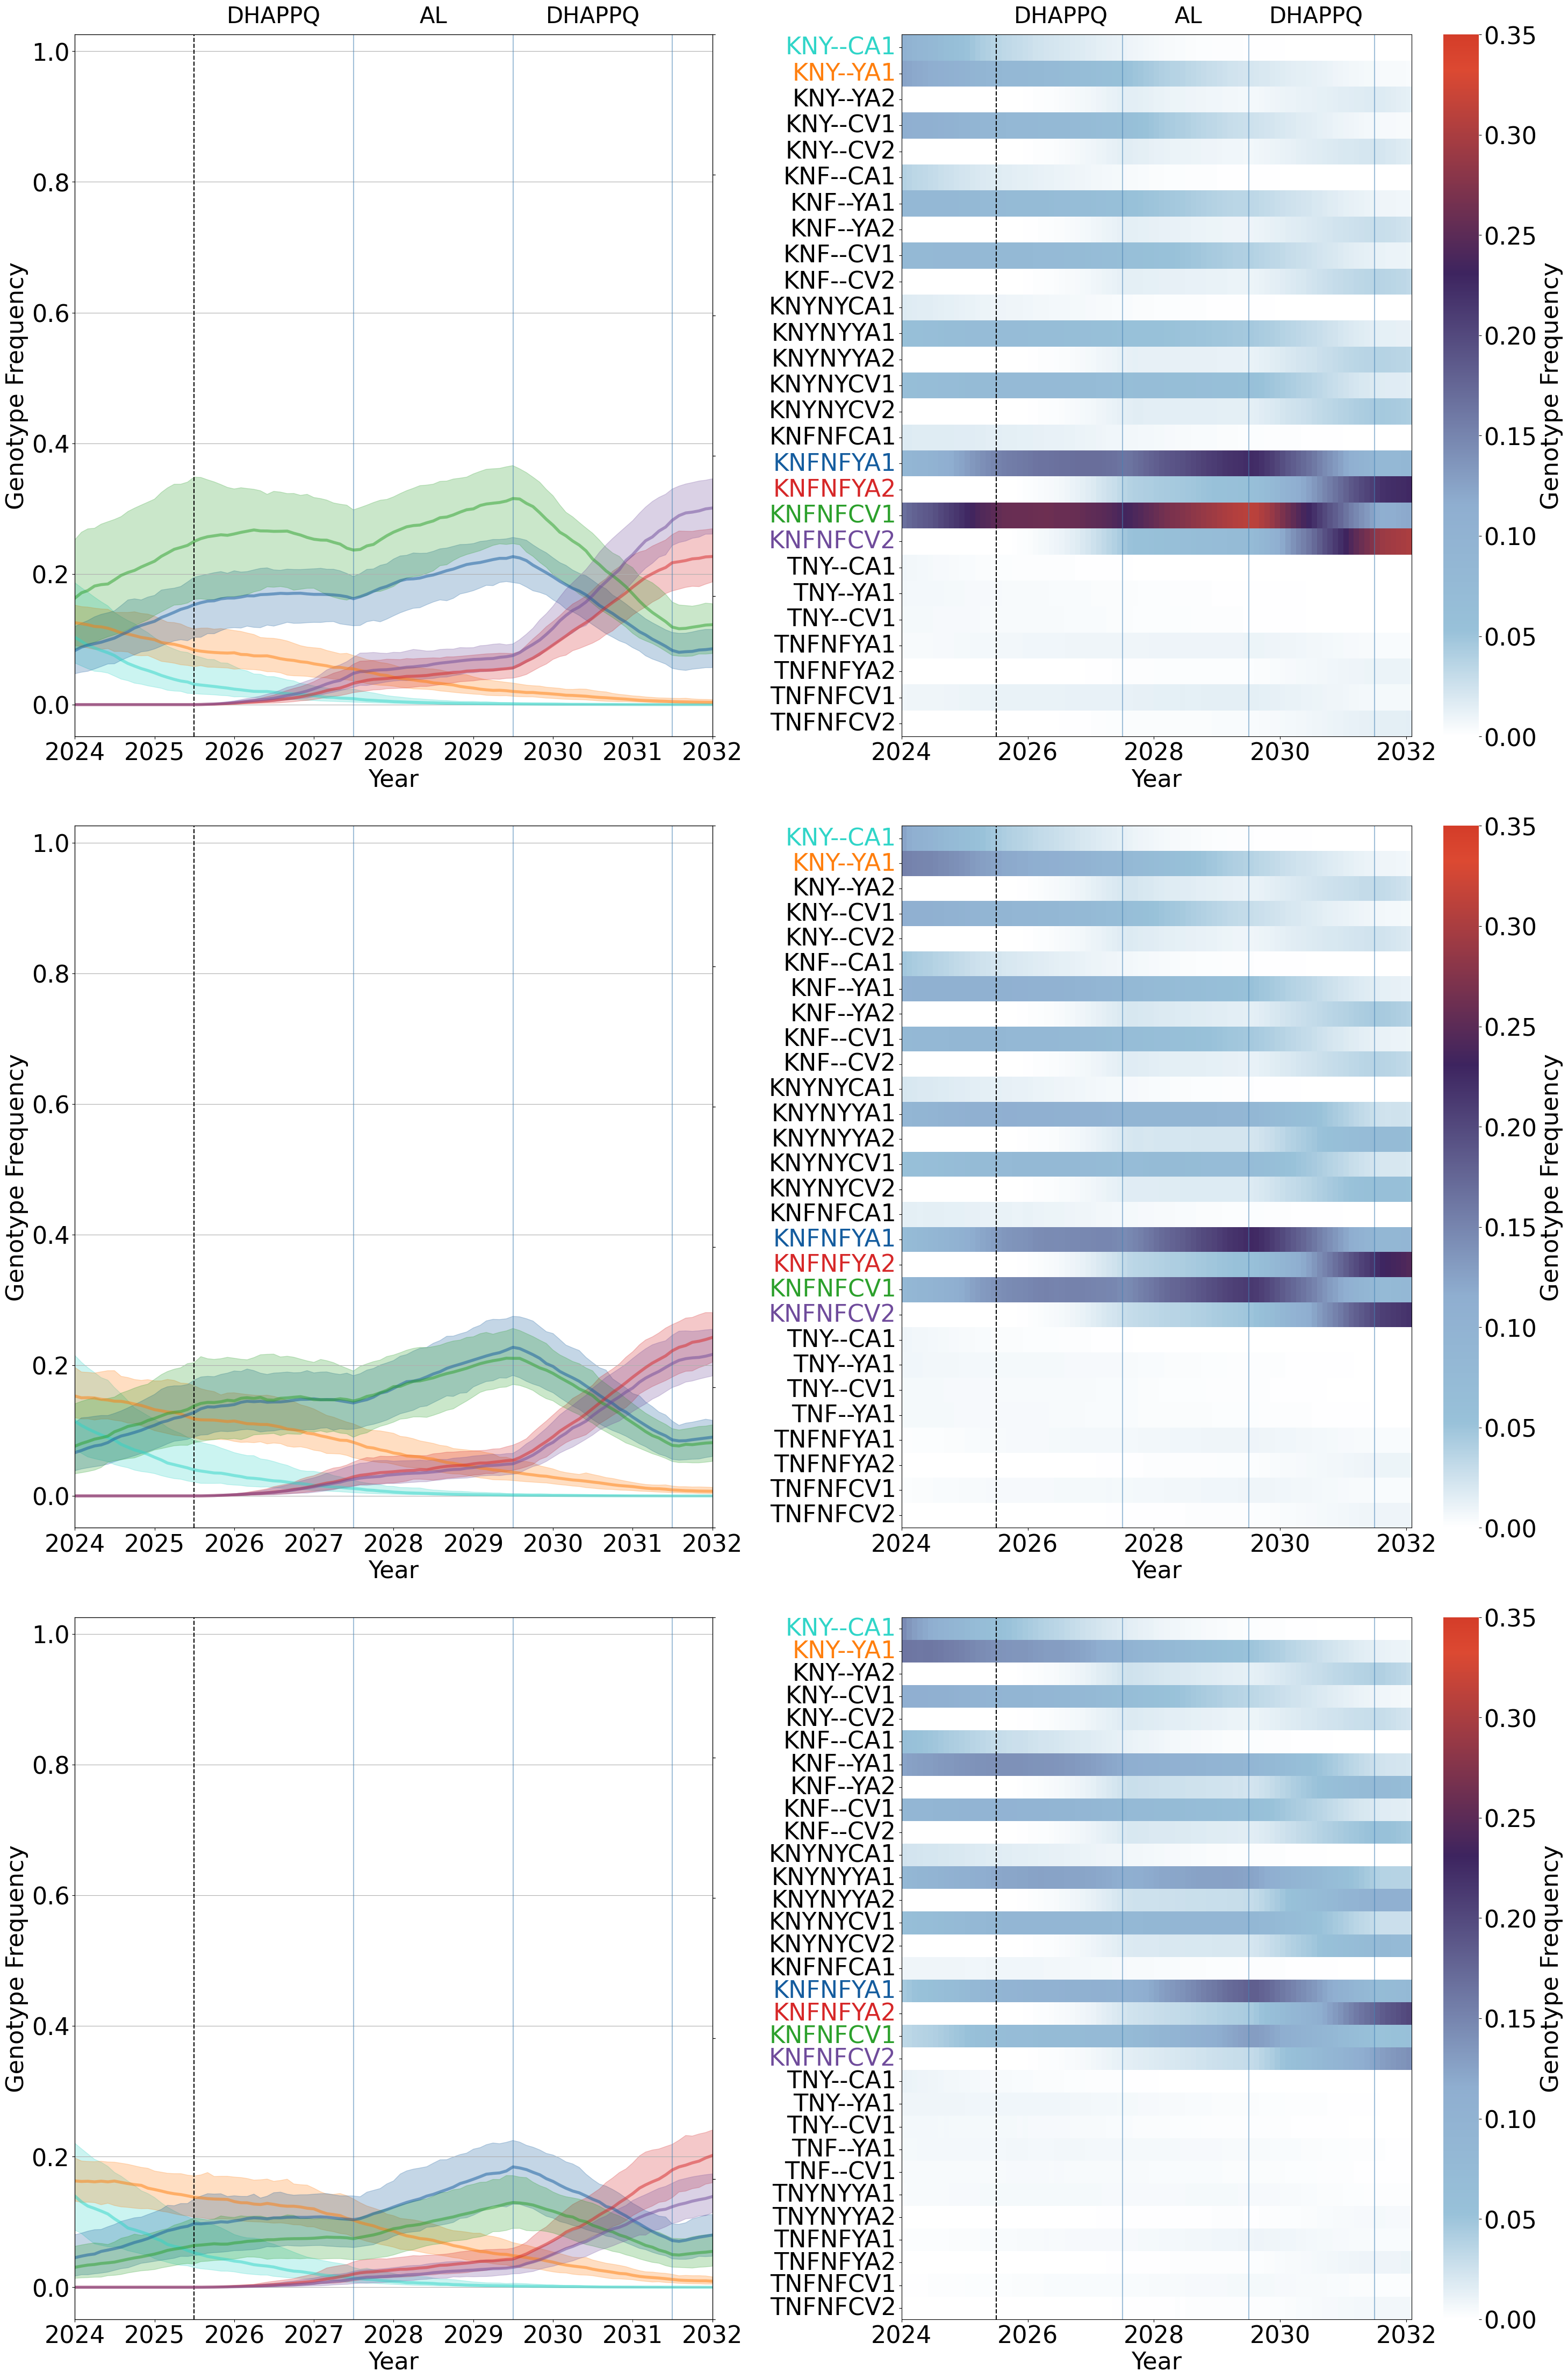

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sqlite3
from datetime import datetime
import numpy as np

def plot_freq_median_iqr(monthly_data, ax, frequency_limit, ylabel, xlimit=None, palette=None, lower_iqr=0.25, upper_iqr=0.75):
    """
    Plots the median and shades the IQR (25th to 75th percentile) for each genotype.

    Args:
    - monthly_data (DataFrame): The input dataframe containing genotype frequency data.
    - ax (matplotlib.axes._subplots.AxesSubplot): The axis on which to plot.
    - palette (str or list): A valid seaborn color palette name or list of colors.
    - frequency_limit (float): The frequency threshold to filter genotypes for plotting.
    """
    # Calculating median and IQR for each genotype
    median_df = monthly_data.groupby("date").median()
    iqr25_df = monthly_data.groupby("date").quantile(lower_iqr)
    iqr75_df = monthly_data.groupby("date").quantile(upper_iqr)

    # Dropping unnecessary columns
    median_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr25_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr75_df.drop(columns=["monthlydataid", "locationid"], inplace=True)

    # Keeping only columns that meet the threshold for median and IQR data
    median_df = median_df.loc[:, (median_df.max() > frequency_limit)]
    iqr25_df = iqr25_df.loc[:, (iqr25_df.max() > frequency_limit)]
    iqr75_df = iqr75_df.loc[:, (iqr75_df.max() > frequency_limit)]

    if palette is not None:
        sns.set_palette(palette)

    # Plotting the median lines for each genotype
    for column in median_df.columns:
        if median_df[column].max() > 0.15:
            plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color="k" if palette is None else None,alpha = 0.5)
        else:
            plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color="gray", alpha=0.0)
        # Shading between IQR 25 and 75 if median values are above the threshold        
        if column in iqr25_df.columns and column in iqr75_df.columns:
            if median_df[column].max() > 0.15:
                ax.fill_between(median_df.index, iqr25_df[column], iqr75_df[column], alpha=0.25)

    # Customize plot (optional, could be part of the function or done outside)
    ax.legend().remove()
    ax.set_ylabel(ylabel)
    if xlimit:
        ax.set_xlim(xlimit)
    else:
        ax.set_xlim(median_df.index.min(), median_df.index.max())
    ax.set_xlabel("Year")
    ax.grid(axis='y')
    
    return median_df,plot

def plot_freq_median_iqr_v2(monthly_data, ax, ylabel, selected_genotypes, xlimit=None, lower_iqr=0.25, upper_iqr=0.75):
    """
    Plots the median and shades the IQR (25th to 75th percentile) for each selected genotype.
    """
    # Calculating median and IQR for each genotype
    median_df = monthly_data.groupby("date").median()
    iqr25_df = monthly_data.groupby("date").quantile(lower_iqr)
    iqr75_df = monthly_data.groupby("date").quantile(upper_iqr)

    # Dropping unnecessary columns
    median_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr25_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr75_df.drop(columns=["monthlydataid", "locationid"], inplace=True)

    # filtering median_df, iqr25_df, iqr75_df to only include selected_genotypes
    median_df = median_df.loc[:, median_df.columns.isin(selected_genotypes.keys())]
    iqr25_df = iqr25_df.loc[:, iqr25_df.columns.isin(selected_genotypes.keys())]
    iqr75_df = iqr75_df.loc[:, iqr75_df.columns.isin(selected_genotypes.keys())]


    # Plotting the median lines for each genotype
    for column in median_df.columns:
        # print(f"Plotting genotype: {column}")
        # get color from selected_genotypes
        color = selected_genotypes.get(column, "gray")
        # plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color=color, alpha=0.0)
        ax.fill_between(median_df.index, iqr25_df[column], iqr75_df[column], alpha=0.25, color=color)
        plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color=color,alpha = 0.5, zorder=3)

    # Customize plot (optional, could be part of the function or done outside)
    ax.legend().remove()
    ax.set_ylabel(ylabel)
    if xlimit:
        ax.set_xlim(xlimit)
    else:
        ax.set_xlim(median_df.index.min(), median_df.index.max())
    ax.set_xlabel("Year")
    ax.grid(axis='y')
    
    return median_df,plot

frequency_limit = 0.005
runs = [1, 10, 30]
sns.reset_defaults()
rc = {
    # "font.family" : "Consolas", 
      "font.style" : "normal",
      "font.size" : 32,
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)

fig,axes = plt.subplots( len(runs),2,figsize=(30,15* len(runs)),sharex=False)
for i, run in enumerate(runs):
# run = 30
    ax0 = axes[i,0]
    ax1 = axes[i,1]
    
    monthly_gen_frequency = pd.read_csv(f"./data/fig4_data_{run}.csv")
    monthly_gen_frequency['date'] = pd.to_datetime(monthly_gen_frequency['date'])
    plot_df = monthly_gen_frequency.groupby("date").mean().drop(columns=["monthlydataid", "locationid"])
    plot_df = plot_df.T

    # Custom colormap: starting with white and going to dark orange
    # cmap = LinearSegmentedColormap.from_list('custom_orange', 
    #     [(0, 'white'), (0.001, '#f0f0f0'),  (0.3, '#fc8d59'), (1, '#7f0000')],  # Gradual transition from white to dark orange
    #                                           N=256)

    colors = [
        (0.0, 'white'),      # 0.0 is white
        (0.15, '#98c1d9'),    # light blue
        (0.33, '#8faed0'),    # more visible blue
        # (0.40, '#6f4b9b'),    # stronger dark violet-blue
        # (0.46, '#4e3378'),    # darker violet
        (0.66, '#3d245f'),    # deep violet
        # (0.75, '#ee6c4d'),    # light orange
        # (0.85, '#e86044'),
        # (0.9, '#e2553b'),
        (0.95, '#dc4932'),
        (1.0, '#d43d29')     # deeper orange
    ]

    cmap= LinearSegmentedColormap.from_list("custom_cmap", colors, N=512)

    date_to_plot = (datetime(2024,1,1), datetime(2032,1,1))

    selected_genotypes = {
        'KNFNFYA1': '#145c9e',
        'KNFNFYA2': '#d62728',
        'KNFNFCV1': '#2ca02c',
        'KNFNFCV2': '#6f4b9b',
        'KNY--CA1': '#30d5c8',
        'KNY--YA1': '#ff7f0e'
    }

    freq_median_df,freq_median_plot = plot_freq_median_iqr_v2(monthly_gen_frequency, ax0, 
                                                         "Genotype Frequency", 
                                                        selected_genotypes, xlimit=date_to_plot,
                                                        lower_iqr=0.05, upper_iqr=0.95)

    #set plot_df column in date_to_plot
    plot_df = plot_df.loc[:,date_to_plot[0]:date_to_plot[1]]

    # Filter genotypes based on the frequency limit
    mask = plot_df.max(axis=1) > frequency_limit
    plot_df = plot_df[mask]

    # Create the heatmap
    plot = sns.heatmap(plot_df, yticklabels=True,xticklabels=True,
                        cmap=cmap, 
                        vmin=0, vmax=0.35, 
                        cbar_kws={'label': 'Genotype Frequency'},
                        ax=ax1)
    
    print(f"max frequency in heatmap for run {run}: {plot_df.values.max()}")
    # plot.collections[0].colorbar.ax.set_ylim(0, 0.5)
    #display border for heatmap
    plot.spines['top'].set_visible(True)
    plot.spines['bottom'].set_visible(True)
    plot.spines['left'].set_visible(True)
    plot.spines['right'].set_visible(True)
    plot_df_columns = [date.strftime('%Y') for date in plot_df.columns]

    #set the color of yticklabels using the same color as the lineplot in axes[0]
    #check if the label name matched label in lineplot
    for label in plot.get_yticklabels():
        if label.get_text() in freq_median_df.columns:
            label.set_color(freq_median_plot.get_lines()[list(freq_median_df.columns).index(label.get_text())].get_color())
        else:
            label.set_color("black")

    xticklabels = [date.strftime('%Y') if (date.month == 1) & (date.year % 2 ==0) else '' for date in plot_df.columns]
    ticks = [i for i, label in enumerate(xticklabels) if label] 
    ax1.set_xticks(ticks=ticks, labels=[xticklabels[i] for i in ticks], rotation=0)  # Adjust rotation if needed
    ax1.set_xlabel('Year')
    pos = np.where(plot_df.columns == datetime(2025, 7, 1))[0][0]
    ax0.axvline(x=datetime(2025,7,1), color='k', linestyle='--')
    ax1.axvline(x=pos, color='k', linestyle='--')
    line_dates = [datetime(2027, 7, 1), datetime(2029, 7, 1), datetime(2031, 7, 1)]
    for line_date in line_dates:
        ax0.axvline(x=line_date, color='#4682B4', linestyle='-', alpha=0.5)
        if line_date in plot_df.columns:
            pos = np.where(plot_df.columns == line_date)[0][0]
            ax1.axvline(x=pos, color='#4682B4', linestyle='-', alpha=0.5)

    # Add three top annotations "DHAPPQ", "AL", "ASAQ" at every 2 years (at the ticks)
    if i == 0: # only first row
        font_size = 30
        drug_labels = ["DHAPPQ", "AL", "DHAPPQ"]
        ncols = plot_df.shape[1]
        # start at 2026-01-01 and step by 2 years (24 months)
        start_pos = np.where(plot_df.columns == datetime(2026, 7, 1))[0][0]
        step = 24
        positions = [p for p in range(start_pos, ncols, step)]
        norm_positions = [p / float(ncols - 1) for p in positions]

        y_start = 1.01

        for j, lbl in enumerate(drug_labels):
            ax1.text(norm_positions[j], y_start, lbl, transform=ax1.transAxes,
                    ha='center', va='bottom', fontsize=30, fontweight='normal')
            ax0.text(norm_positions[j], y_start, lbl, transform=ax0.transAxes,
                    ha='center', va='bottom', fontsize=30, fontweight='normal')

    #create different axis for pfpr and treatment failures to plot on ax0
    axes_pfpr = ax0.twinx()
    axes_tf = ax0.twinx()

    # plot_median_iqr(monthly_pfpr, axes_pfpr, 0, "PfPR", xlimit=date_to_plot, color="k")
    # plot_median_iqr(monthly_tf, axes_tf, 0, "Treatment Failures", xlimit=date_to_plot, color="k")

    axes_pfpr.set_yticklabels([])
    axes_tf.set_yticklabels([])
    axes_pfpr.set_ylabel("")
    axes_tf.set_ylabel("")

plt.tight_layout()
plt.show()
fig.savefig(f"figure_4.png", dpi=300)

# Figure 5

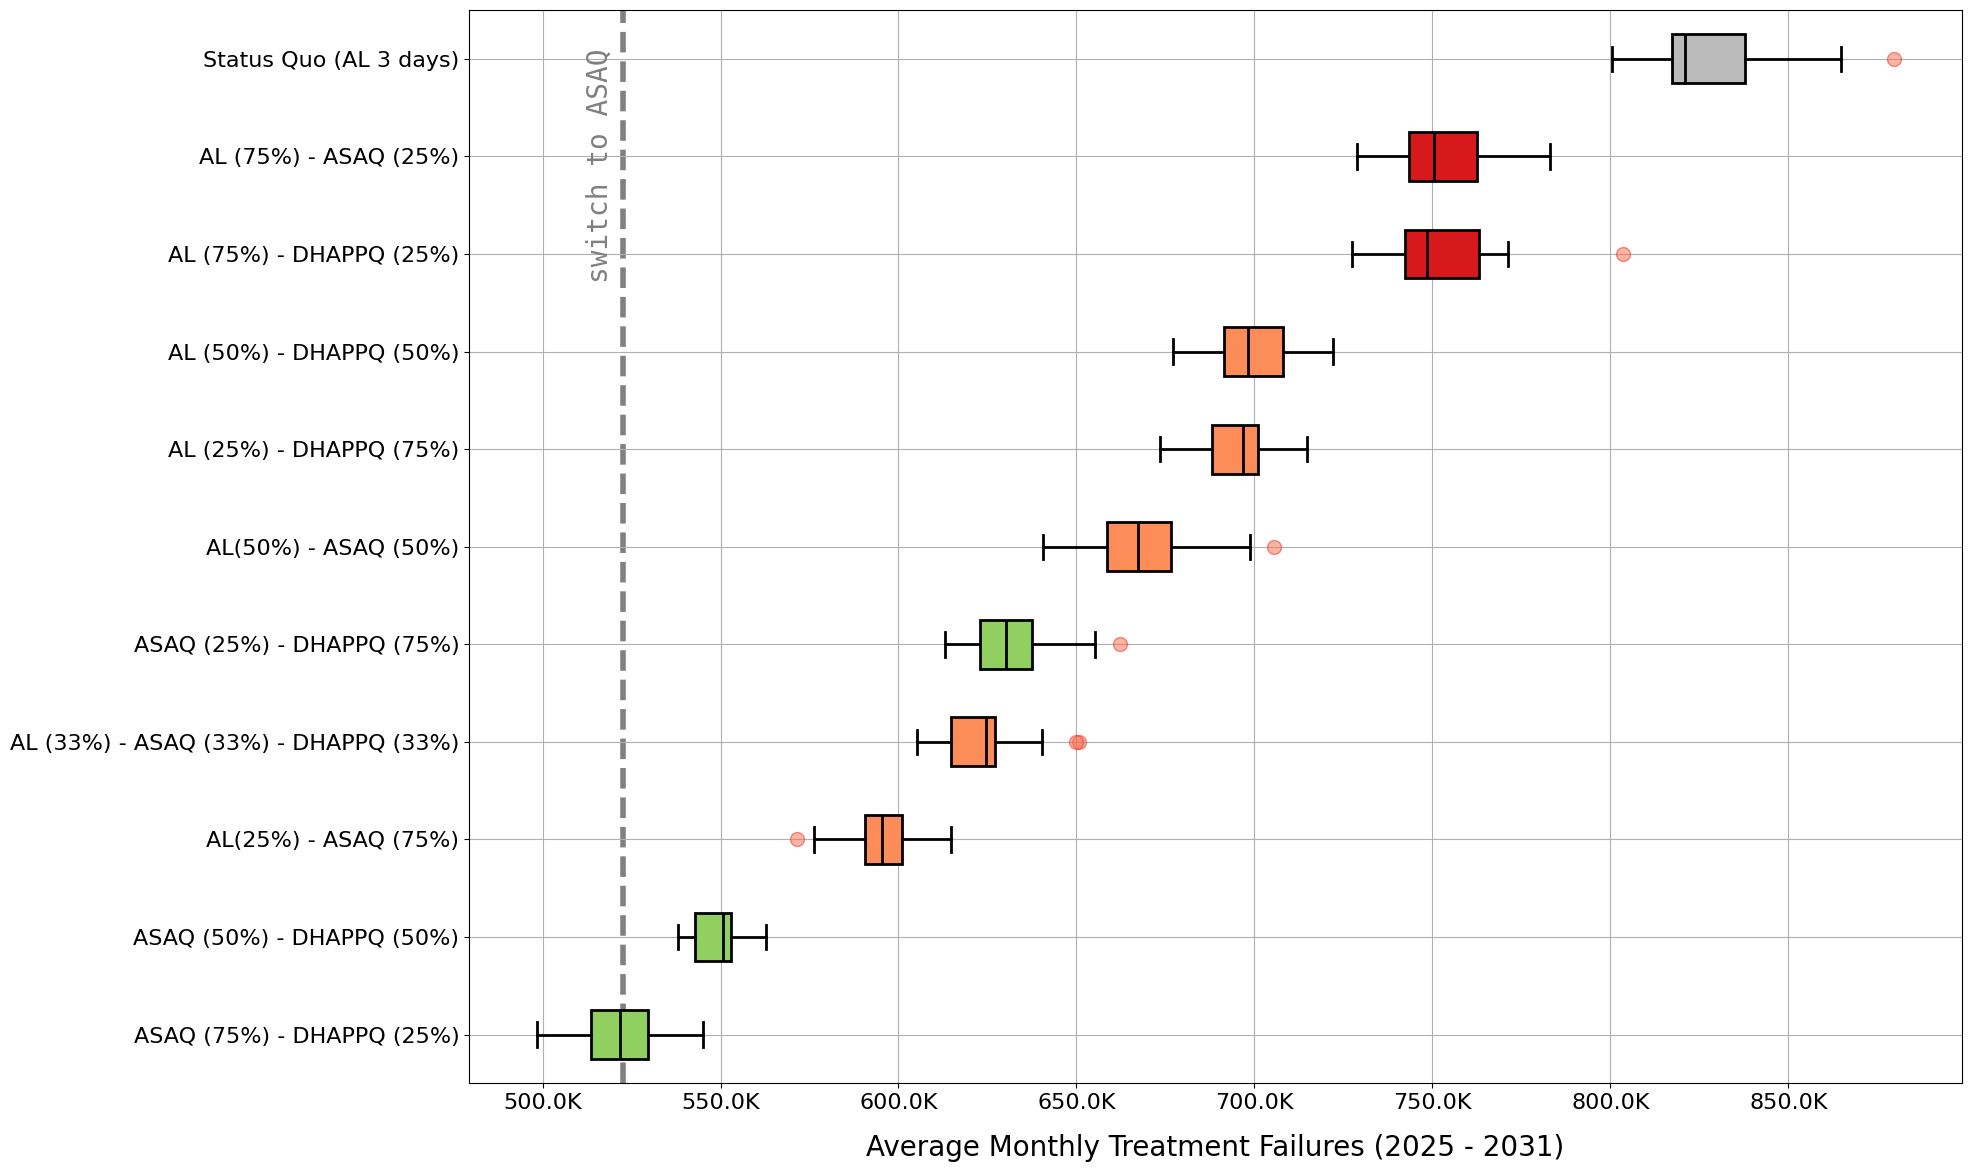

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter


# Custom formatter function for x-axis
def millions_formatter(x, pos):
    return f'{int(x) / 1e6}M'

# Custom formatter function for x-axis
def thousands_formatter(x, pos):
    return f'{int(x) / 1e3}K'

#setting
scenario_mapping = {
    "status_quo": {"label": "Status Quo (AL 3 days)", "color": "#bababa", "position": 0},
    "mft_al75_asaq25": {"label": "AL (75%) - ASAQ (25%)", "color": "#d7191c", "position": 0},
    "mft_al75_dhappq25": {"label": "AL (75%) - DHAPPQ (25%)", "color": "#d7191c", "position": 0},
    "mft_al50_dhappq50": {"label": "AL (50%) - DHAPPQ (50%)", "color": "#fc8d59", "position": 0},
    "mft_al25_dhappq75": {"label": "AL (25%) - DHAPPQ (75%)", "color": "#fc8d59", "position": 0},
    "mft_al50_asaq50": {"label": "AL(50%) - ASAQ (50%)", "color": "#fc8d59", "position": 0},
    "mft_asaq25_dhappq75": {"label": "ASAQ (25%) - DHAPPQ (75%)", "color": "#91cf60", "position": 0},
    "mft_al_asaq_dhappq": {"label": "AL (33%) - ASAQ (33%) - DHAPPQ (33%)", "color": "#fc8d59", "position": 0},
    "mft_al25_asaq75": {"label": "AL(25%) - ASAQ (75%)", "color": "#fc8d59", "position": 0},
    "mft_asaq50_dhappq50": {"label": "ASAQ (50%) - DHAPPQ (50%)", "color": "#91cf60", "position": 0},
    "mft_asaq75_dhappq25": {"label": "ASAQ (75%) - DHAPPQ (25%)", "color": "#91cf60", "position": 0},
    # "mft_al5_asaq_dhappq": {"label": "AL 5 days (33%) - ASAQ (33%) - DHAPPQ (33%)", "color": "#91cf60", "position": 0},
}
for i, key in enumerate(scenario_mapping):
    scenario_mapping[key]['position'] = -i
group_endings = ["mac_dhppq_al_789"] 


# Load the dataset
data_path = './data/ntfs_6y.csv'
data_labeled = pd.read_csv(data_path)
data_labeled = data_labeled [ (data_labeled["scenario"].isin(scenario_mapping.keys())) & (data_labeled["year"] == 2031)]
data_labeled["total_treatmentfailures"] = data_labeled["total_treatmentfailures"] / (12*6)


data_labeled['position'] = data_labeled['scenario'].apply(lambda x: scenario_mapping[x]['position'])

# Introduce variables for box width and spacing
box_width = 0.2  # Can be adjusted for narrower or wider boxes
spacing_multiplier = 0.4  # Adjust this to make boxplots closer or further apart
dynamic_positions = {scenario: details["position"] * spacing_multiplier for scenario, details in scenario_mapping.items()}

# Calculate dynamic positions for dashed lines
adjusted_group_separators = [dynamic_positions[scenario] - 0.5 * spacing_multiplier for scenario in group_endings[:-1]]  # Adjust, exclude last

plt.rcdefaults()
plt.rcParams['font.size'] = 16
lw=2
outlier_size=10
# Create the plots with corrected positions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12), sharey=False, sharex=False)
# box_plot_for_a_year(axes, data_labeled, 2029, dynamic_positions, adjusted_group_separators, is_first_column=True)
for scenario, details in scenario_mapping.items():
    scenario_data = data_labeled[(data_labeled['scenario'] == scenario) & (data_labeled['year'] == 2031)]['total_treatmentfailures']
    if not scenario_data.empty:
        ax.boxplot(scenario_data, positions=[dynamic_positions[scenario]], 
                    widths=box_width, vert=False, patch_artist=True,
                    boxprops=dict(facecolor=details['color'], color='black',  linewidth=lw),
                    whiskerprops=dict(color='black',linewidth=lw),
                    capprops=dict(color='black', linewidth=lw),
                    medianprops=dict(color='black', linewidth=lw),
                    flierprops=dict(marker='o', markerfacecolor='#fb6a4a',markeredgecolor='#de2d26', alpha=0.5,markersize=outlier_size)
                    )

ax.axvline(
    x=522456,  # Line position
    c="grey",  # Line color
    linewidth=4,  # Line thickness
    linestyle = '--',
    zorder=0,  # Ensure it renders behind the bars
    clip_on=True,  # Allow line to extend beyond axes
)

ax.text(
    520000,  # Position on the x-axis
    -0.44,  # Position on the y-axis
    "switch to ASAQ",
    fontweight="normal",
    fontname='monospace',
    fontsize = 20,
    color="grey",
    rotation=90,
    va="center",
    ha="right",
)

# ax.set_xlim(300000, 580000)
min_y = min(dynamic_positions.values()) - 0.5 * spacing_multiplier
max_y = max(dynamic_positions.values()) + 0.5 * spacing_multiplier
ax.set_ylim(min_y, max_y)

ax.set_yticklabels([details["label"] for scenario, details in scenario_mapping.items()])
ax.set_xlabel('Average Monthly Treatment Failures (2025 - 2031)', fontsize=20, labelpad=15)
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the custom formatter
ax.grid(axis='both')

plt.tight_layout()
plt.savefig("figure_5.png", dpi=300)

plt.show()

# Figure 6

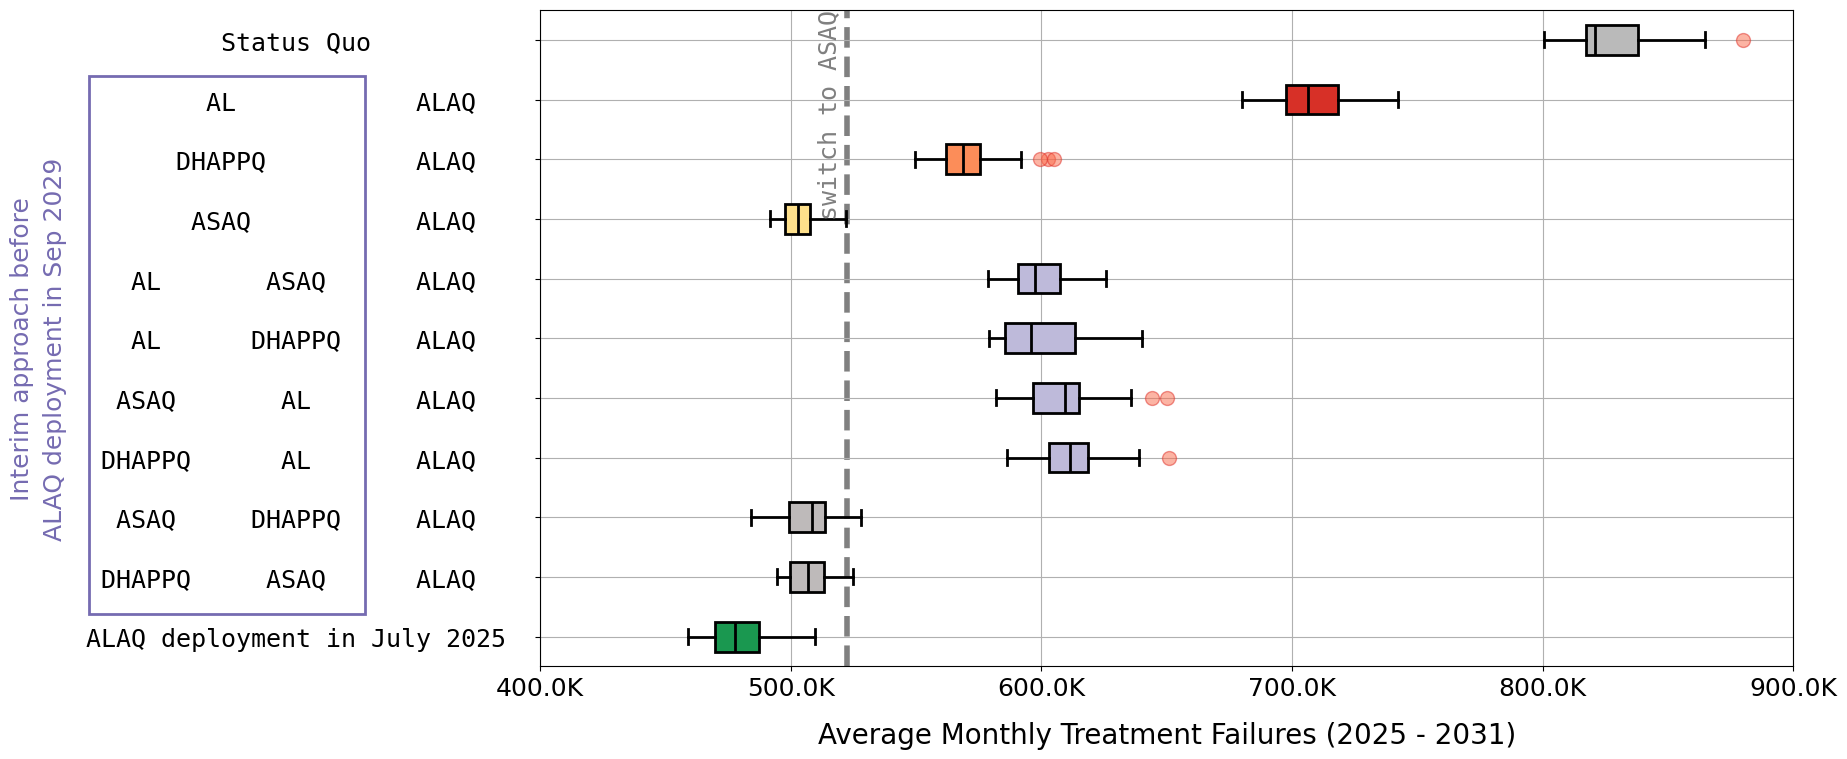

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch


# Custom formatter function for x-axis
def millions_formatter(x, pos):
    return f'{int(x) / 1e6}M'

# Custom formatter function for x-axis
def thousands_formatter(x, pos):
    return f'{int(x) / 1e3}K'
#setting
corrected_scenario_mapping_dict = {
    "status_quo": {"label": "Status Quo (AL 3 days)", "color": "#bababa", "position": 0},
    "tact_al4y_alaq": {"label": "Status quo (4 years), then ALAQ", "color": "#d73027", "position": 0},
    "tact_dhappq4y_alaq": {"label": "DHAPPQ (4 years), then ALAQ", "color": "#fc8d59", "position": 0},
    "tact_asaq4y_alaq": {"label": "ASAQ (4 years), then ALAQ", "color": "#fee08b", "position": 0},
    "tact_al_asaq_alaq": {"label": "Triple-ACT: AL (2 years), ASAQ (2 years), then ALAQ", "color": "#bebada", "position": 0},
    "tact_al_dhappq_alaq": {"label": "Triple-ACT: AL (2 years), DHAPPQ (2 years), then ALAQ", "color": "#bebada", "position": 0},
    "tact_asaq_al_alaq": {"label": "Triple-ACT: ASAQ (2 years), AL (2 years), then ALAQ", "color": "#bebada", "position": 0},
    "tact_dhappq_al_alaq": {"label": "Triple-ACT: DHAPPQ (2 years), AL (2 years), then ALAQ", "color": "#bebada", "position": 0},
    "tact_asaq_dhappq_alaq": {"label": "ASAQ (2 years), DHAPPQ (2 years), then ALAQ", "color": "#bebaba", "position": 0},
    "tact_dhappq_asaq_alaq": {"label": "DHAPPQ (2 years), ASAQ (2 years), then ALAQ", "color": "#bebaba", "position": 0},
    "tact_alaq": {"label": "ALAQ deployment in Sept 2024", "color": "#1a9850", "position": 0},
}
for i, key in enumerate(corrected_scenario_mapping_dict):
    corrected_scenario_mapping_dict[key]['position'] = -i
group_endings = ["mac_dhppq_al_789"] 

total_width = 30
col_width_3 = total_width // 3  # Width for each column in 3-column rows

# Extract labels from the dictionary, split by "-" and format them
y_ticks_dynamic = [
    f"{'Status Quo':^{total_width}}",
    f"{'AL':^{total_width*2//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'DHAPPQ':^{total_width*2//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'ASAQ':^{total_width*2//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'AL':^{total_width*1//3}}{'ASAQ':^{total_width*1//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'AL':^{total_width*1//3}}{'DHAPPQ':^{total_width*1//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'ASAQ':^{total_width*1//3}}{'AL':^{total_width*1//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'DHAPPQ':^{total_width*1//3}}{'AL':^{total_width*1//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'ASAQ':^{total_width*1//3}}{'DHAPPQ':^{total_width*1//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'DHAPPQ':^{total_width*1//3}}{'ASAQ':^{total_width*1//3}}{'ALAQ':^{total_width*1//3}}",
    f"{'ALAQ deployment in July 2025':^{total_width}}",
]


# Load the dataset
data_path = './data/ntfs_6y.csv'
data_labeled = pd.read_csv(data_path)
data_labeled = data_labeled [ (data_labeled["scenario"].isin(corrected_scenario_mapping_dict.keys())) & (data_labeled["year"] == 2031)]
data_labeled["total_treatmentfailures"] = data_labeled["total_treatmentfailures"] / (6*12)

data_labeled['position'] = data_labeled['scenario'].apply(lambda x: corrected_scenario_mapping_dict[x]['position'])

# Introduce variables for box width and spacing
box_width = 0.2  # Can be adjusted for narrower or wider boxes
spacing_multiplier = 0.4  # Adjust this to make boxplots closer or further apart
dynamic_positions = {scenario: details["position"] * spacing_multiplier for scenario, details in corrected_scenario_mapping_dict.items()}

# Calculate dynamic positions for dashed lines
adjusted_group_separators = [dynamic_positions[scenario] - 0.5 * spacing_multiplier for scenario in group_endings[:-1]]  # Adjust, exclude last

plt.rcdefaults()
plt.rcParams['font.size'] = 18
lw=2
outlier_size=10
# Create the plots with corrected positions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), sharey=False, sharex=False)
# box_plot_for_a_year(axes, data_labeled, 2029, dynamic_positions, adjusted_group_separators, is_first_column=True)
for scenario, details in corrected_scenario_mapping_dict.items():
    scenario_data = data_labeled[(data_labeled['scenario'] == scenario) & (data_labeled['year'] == 2031)]['total_treatmentfailures']
    if not scenario_data.empty:
        ax.boxplot(scenario_data, positions=[dynamic_positions[scenario]], 
                    widths=box_width, vert=False, patch_artist=True,
                    boxprops=dict(facecolor=details['color'], color='black',  linewidth=lw),
                    whiskerprops=dict(color='black',linewidth=lw),
                    capprops=dict(color='black', linewidth=lw),
                    medianprops=dict(color='black', linewidth=lw),
                    flierprops=dict(marker='o', markerfacecolor='#fb6a4a',markeredgecolor='#de2d26', alpha=0.5,markersize=outlier_size)
                    )
# Set tick positions and custom labels
ax.set_yticks(list(dynamic_positions.values()))
ax.set_yticklabels(y_ticks_dynamic, fontname='monospace') 

# Adjust tick parameters for better padding
ax.tick_params(axis='y', pad=10)

        
ax.axvline(
    x=522456,  # Line position
    c="grey",  # Line color
    linewidth=4,  # Line thickness
    linestyle = '--',
    zorder=0,  # Ensure it renders behind the bars
    clip_on=True,  # Allow line to extend beyond axes
)

ax.text(
    520000,  # Position on the x-axis
    -0.5,  # Position on the y-axis
    "switch to ASAQ",
    fontweight="normal",
    fontname='monospace',
    fontsize = 18,
    color="grey",
    rotation=90,
    va="center",
    ha="right",
)


# Add the text
ax.text(-0.4, 0.2, 'Interim approach before\nALAQ deployment in Sep 2029',
        transform=ax.transAxes,
        zorder=101, 
        clip_on=False, 
        rotation= 90, horizontalalignment='center',
        linespacing=1.5,
        color = '#756bb1'
        )
# ## rectangle annotation
rect = Rectangle((-0.36, 0.08), 0.22, 0.82, 
                transform=ax.transAxes,
                 linewidth=2, 
                 edgecolor='#756bb1', facecolor='none',
                 zorder=100,
                 clip_on=False)
ax.add_patch(rect)

ax.set_xlim(400000, 900000)

min_y = min(dynamic_positions.values()) - 0.5 * spacing_multiplier
max_y = max(dynamic_positions.values()) + 0.5 * spacing_multiplier
ax.set_ylim(min_y, max_y)
# ax.set_yticklabels([details["label"] for scenario, details in corrected_scenario_mapping_dict.items()])
ax.set_xlabel('Average Monthly Treatment Failures (2025 - 2031)', fontsize=20, labelpad=15)
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the custom formatter
ax.grid(axis='both')

plt.tight_layout()
plt.savefig(f"figure_6.png", dpi=300)
plt.show()

# Figure 7

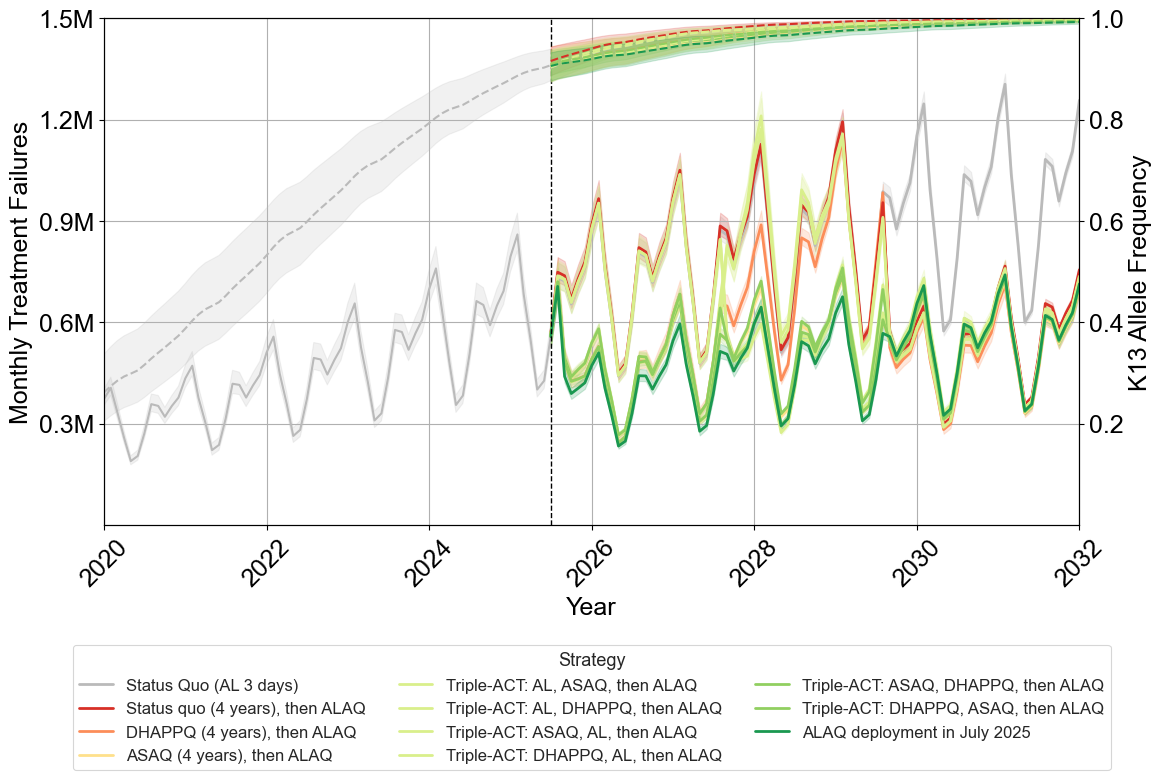

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import pandas as pd

# Load data
df = pd.read_csv("./data/fig7_data.csv", parse_dates=["date"])
critical_point = pd.to_datetime("2025-07-01")

# Formatter for millions
def millions_formatter(x, pos):
    return f'{x * 1e-6:.1f}M'

# Colors
cold_color = '#bababa'
palette_after = {
    "status_quo": "#bababa",
    "tact_dhappq4y_alaq": "#fc8d59",
    "tact_al4y_alaq": "#d73027", 
    "tact_asaq4y_alaq": "#fee08b", 
    "tact_al_asaq_alaq": "#d9ef8b", 
    "tact_al_dhappq_alaq": "#d9ef8b", 
    "tact_asaq_al_alaq": "#d9ef8b",  
    "tact_dhappq_al_alaq": "#d9ef8b", 
    "tact_dhappq_asaq_alaq": "#91cf60", 
    "tact_asaq_dhappq_alaq": "#91cf60",  
    "tact_alaq": "#1a9850",
}

# Scenario labels for legend
scenario_labels = {
    "status_quo": "Status Quo (AL 3 days)",
    "tact_al4y_alaq": "Status quo (4 years), then ALAQ",
    "tact_dhappq4y_alaq": "DHAPPQ (4 years), then ALAQ",
    "tact_asaq4y_alaq": "ASAQ (4 years), then ALAQ",
    "tact_al_asaq_alaq": "Triple-ACT: AL, ASAQ, then ALAQ",
    "tact_al_dhappq_alaq": "Triple-ACT: AL, DHAPPQ, then ALAQ",
    "tact_asaq_al_alaq": "Triple-ACT: ASAQ, AL, then ALAQ",
    "tact_dhappq_al_alaq": "Triple-ACT: DHAPPQ, AL, then ALAQ",
    "tact_asaq_dhappq_alaq": "Triple-ACT: ASAQ, DHAPPQ, then ALAQ",
    "tact_dhappq_asaq_alaq": "Triple-ACT: DHAPPQ, ASAQ, then ALAQ",
    "tact_alaq": "ALAQ deployment in July 2025",
}

# Setup figure
fig, ax1 = plt.subplots(figsize=(12, 10))
ax2 = ax1.twinx()

sns.set_context("paper", font_scale=2)
sns.set_style("whitegrid")

# Split data into pre- and post-policy change
pre = df[df["date"] <= critical_point]
post = df[df["date"] >= critical_point]

# Plot pre-policy data
sns.lineplot(data=pre, x="date", y="total_treatmentfailures", ax=ax1,
             color=cold_color, lw=1.5, errorbar=("pi", 90))
sns.lineplot(data=pre, x="date", y="k13_frequency", ax=ax2,
             color=cold_color, lw=1.5, linestyle='--', errorbar=("pi", 90))

# Plot post-policy data by scenario
for scenario in df["scenario"].dropna().unique():
    data_post = post[post["scenario"] == scenario]
    if scenario in palette_after:
        sns.lineplot(data=data_post, x="date", y="total_treatmentfailures", ax=ax1,
                     color=palette_after[scenario], lw=2, errorbar=("pi", 90))
        sns.lineplot(data=data_post, x="date", y="k13_frequency", ax=ax2,
                     color=palette_after[scenario], lw=1.5, linestyle='--', errorbar=("pi", 90))

# Vertical policy line
ax1.axvline(critical_point, color='black', linestyle='--', lw=1)

# Axis formatting
# Left Y-axis (Treatment Failures)
ax1.set_ylabel("Monthly Treatment Failures")
ax1.set_ylim([0, 1.5e6])
left_yticks = [0.3e6 * i for i in range(1, 6)]  # [0.3e6, 0.6e6, ..., 1.5e6]
ax1.set_yticks(left_yticks)
ax1.yaxis.set_major_formatter(millions_formatter)

# Right Y-axis (K13 Frequency)
ax2.set_ylabel("K13 Allele Frequency")
ax2.set_ylim([0, 1.0])
right_yticks = [round(0.2 * i, 1) for i in range(1, 6)]  # [0.2, 0.4, ..., 1.0]
ax2.set_yticks(right_yticks)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:.1f}"))


# X-axis formatting
ax1.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2032-01-01"))
ax1.set_xlabel("Year")
ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, axis='both')
ax2.grid(False)

# Legend
custom_handles = [
    Line2D([0], [0], color=palette_after[key], lw=2)
    for key in scenario_labels if key in palette_after
]

ax1.legend(custom_handles, [scenario_labels[k] for k in scenario_labels if k in palette_after],
           title="Strategy", loc='lower center', bbox_to_anchor=(0.5, -0.5),
           ncol=3, fancybox=True, frameon=True, fontsize=12, title_fontsize=13)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("figure_7.png", dpi=300, bbox_inches='tight')
plt.show()


# Figure 8

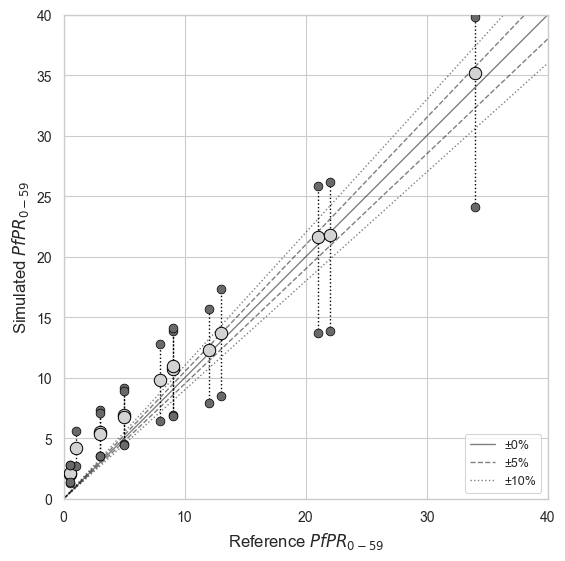

In [10]:
## plot  treatments vs pfpr 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plot_data = pd.read_csv("./data/fig8c_data.csv")

# Extract necessary columns
x = plot_data["mis_pfpr_2018"]
y_median = plot_data["region_pfpr_median"]
y_min = plot_data["region_pfpr_min"]
y_max = plot_data["region_pfpr_max"]

# set the size of the plot
plt.figure(figsize=(6, 6), dpi=100)

# Central and deviation reference lines
plt.plot([0, 40], [0, 40], color='black', linewidth=1, alpha=0.5, label='±0%')
plt.plot([0, 40], [0, 40 * 0.95], color='black', linestyle='--', linewidth=1, alpha=0.5, label='±5%')
plt.plot([0, 40], [0, 40 * 0.90], color='black', linestyle=':', linewidth=1, alpha=0.5, label='±10%')
plt.plot([0, 40], [0, 40 * 1.05], color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.plot([0, 40], [0, 40 * 1.10], color='black', linestyle=':', alpha=0.5, linewidth=1)

# Vertical error bars (min-max)
for xi, ymin, ymax in zip(x, y_min, y_max):
    plt.plot([xi, xi], [ymin, ymax], color='black', linestyle='dotted', linewidth=1)

# Median points
sns.scatterplot(data=plot_data, x="mis_pfpr_2018", y="region_pfpr_median", facecolors='lightgray', edgecolor='black', s=80, zorder=4)
sns.scatterplot(data=plot_data, x="mis_pfpr_2018", y="region_pfpr_min", facecolor="dimgray", edgecolor='black', s=40, zorder=4)
sns.scatterplot(data=plot_data, x="mis_pfpr_2018", y="region_pfpr_max", facecolor='dimgray', edgecolor = 'black', s=40, zorder=4)

# Labels and layout
# plt.xlabel("Reference PfPR$_{0-59}$", fontsize=12)
# plt.ylabel("Simulated PfPR$_{0-59}$", fontsize=12)
plt.xlabel(r"Reference $\mathit{PfPR}_{0-59}$", fontsize=12)
plt.ylabel(r"Simulated $\mathit{PfPR}_{0-59}$", fontsize=12)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right', fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.savefig("figure_8c.png", dpi=300)
plt.show()

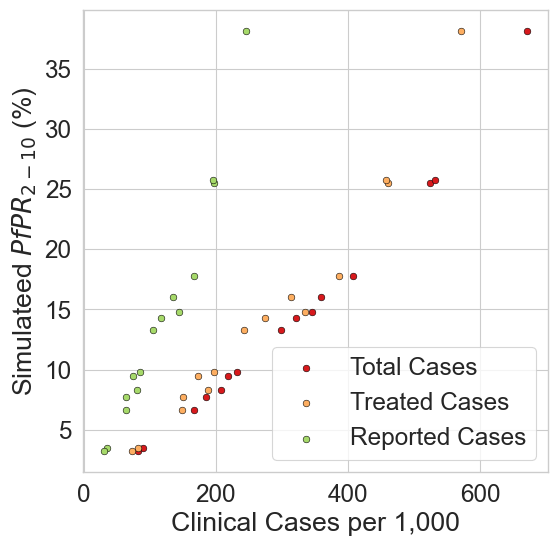

In [11]:
## plot  treatments vs pfpr 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# set the size of the plot
plt.figure(figsize=(6, 6), dpi=100)

region_pfpr_median = pd.read_csv("./data/fig8d_data.csv")
sns.scatterplot(data=region_pfpr_median, x="total_cases", y="simulated_pfpr", color="#d7191c", edgecolors="black")
sns.scatterplot(data=region_pfpr_median, x="treated_cases", y="simulated_pfpr", color="#fdae61", edgecolors="black")
sns.scatterplot(data=region_pfpr_median, x="reported_cases", y="simulated_pfpr", color="#a6d96a", edgecolors="black")

# set x and y label
plt.xlabel("Clinical Cases per 1,000")
# italic Pfpr and under 2-10
plt.ylabel(r"Simulateed $\mathit{PfPR_{2-10}}$ (%)")

# show legend in the plot, bottom right
plt.legend(["Total Cases", "Treated Cases", "Reported Cases"], loc="lower right")

plt.savefig("figure_8d.png", dpi=300)
plt.show()